In [95]:
import pdb
import numpy as np
import pulp as plp
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pltt
import matplotlib.ticker as ticker
import csv
import pandas as pd

from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.optimize import Bounds
from scipy.optimize import BFGS
from scipy import stats
from scipy.spatial import distance

from math import pi, cos, sin
from random import random


In [96]:
class Robot:
    def __init__(self,idn,position,prior_dist,time_left,final_positions,print_option,version):
        # ID of Agent 1..n (Starts from 0, to keep indices consistent with object methods)
        self.idn=idn
        
        # Each i has a distribution for its and others final position over a discrete set of positions.
        # Each robot keeps a matrix of positions for n x m 
        # where n is the number of agents, and m is the set of final destinations
        self.dist=np.copy(prior_dist)
        
        #Can written as more memory-effective
        self.dist_ji=np.copy(prior_dist)
        
        # To determine positions at each time step, it is important to keep time left, firstly it can be T.
        self.time=np.copy(time_left+1)
        self.time_inc=2
        self.giv_time=np.copy(time_left+1)
        
        #The position of each robot should be defined and kept to track the movement.
        self.pos=np.copy(position)
        self.allPos=np.reshape(position,(1,2))
        
        #Position of final access points
        self.finals=final_positions
        
        self.weights_alpha=np.zeros(self.dist.shape[0]-1)
        self.weights_x=np.zeros(self.dist.shape[0]-1)
        self.alpha=np.zeros(self.dist.shape[0]-1)
        
        #Communication Cardinality
        self.comCard=0
        self.comMat=np.zeros((prior_dist.shape[0],prior_dist.shape[1]))
        
        
        #Total Communication Attempt
        self.total_attempt=np.array([])
        
        #Keeping previous selection of target
        self.selPos=np.empty(self.dist.shape[1])
        self.prev_selected=np.empty(self.dist.shape[1])
        
        ##Communication index -i
        com_list=np.arange(self.dist.shape[0])
        self.com_list=np.delete(com_list,self.idn)
        #pdb.set_trace()
        ## f^i_i(t): own estimates over time
        
        self.own_estimate=np.zeros((time_left,self.dist.shape[1]))
        
        dif=self.finals-self.pos
        d_i0=np.linalg.norm(dif,axis=1)
        
        self.distances=np.copy(d_i0)
        
        #Plot stats
        #Number of received succesful communication on each iteration
        
        self.recSuc=np.array([])
        
        #Count the number of routing variables over 1/N-1 
        self.comAt=np.array([])
        
        #Distance between pure actions and f_i
        self.difPures=np.array([])
        
        #Estimataed Utility function U(a_it, f^it)
        self.selPosObj=np.array([])
        
        #Print the results if 1
        self.print_option=print_option
        
        #For experiments, 
        #Version 0: Our full algorithm
        #Version 1: Learning aware communication included, but mobility control not
        #Version 2: Benchmark Case, no communication and mobility control
        self.version=version
        
        
    def getComAt(self):
            return self.comAt
        
    def getRecSuc(self):
            return self.recSuc
        
        
    def getOwnEst(self):
        
        return self.own_estimate
        
    def getWeight_alpha(self,rho_1,threshold,threshold_2,prob_eps,t):
        
        weights_alpha=np.zeros(self.dist.shape[0]-1)
        
        # At each time step, it updates the distribution of 
        
        #sol=self.selectPos(prob_eps,t)
        sol=self.getSelPos()
        prev_dist=np.copy(self.dist[self.idn])
        
        #Smooth the previous distribution with the current solution
        
        self.dist[self.idn]=(1-rho_1)*prev_dist+rho_1*sol
        
        #pdb.set_trace()
        #self.dist[self.idn]=self.dist[self.idn]/np.sum(self.dist[self.idn])
        
        dif_pure=self.difPure()
            
            
        dif_ji=np.linalg.norm(self.dist[self.idn]-self.dist_ji[self.com_list],axis=1)
        
        #pdb.set_trace()
            
        #weights_x=np.zeros(self.dist.shape[0]-1)
            
        for k in range(self.dist.shape[0]-1):
                
            #pdb.set_trace() 
            if(dif_pure > threshold or dif_ji[k]> threshold_2):
                #pdb.set_trace()
                dif_dist_others=np.linalg.norm(self.dist[self.com_list[k]]-self.dist[self.idn])
                weights_alpha[k]=np.amin([10,1/dif_dist_others])
        
        self.own_estimate[self.time_inc-2,:]=self.dist[self.idn]
        
        
        ## Distance to pure action ||f_t-a_ik||
        #self.difPure()
        
        
        
        
        if(self.print_option==1):
            print("Robot "+str(self.idn)+" dist is "+str(self.dist[self.idn])+"before communication")
        
        #KL-Divergence
        #div_log=np.log(np.true_divide(self.dist[self.idn], prev_dist))
        #kl_div=np.dot(self.dist[self.idn],div_log)
        
        #kl_div=self.getKL(self.dist[self.idn],prev_dist)
        
        #if(kl_div >= threshold):
        #  weights_alpha=np.power(self.getDistances(),-1)
        
        
        #dif_dist= np.linalg.norm(self.dist[self.idn]-prev_dist)/rho_1
        
        #pdb.set_trace()
        #print("Difference from prev dist is "+str(dif_dist))
               
        #inds=np.ones(self.dist.shape[0],dtype=bool) 
        #inds[self.idn]=False
        
        
        #if(dif_dist >= threshold):
            
            #dif_dist_others=np.linalg.norm(self.dist[inds]-self.dist[self.idn],axis=1)+10**-6
            #weights_alpha= np.true_divide(dif_dist,dif_dist_others)
            
           # weights_alpha=weights_alpha/np.linalg.norm(weights_alpha)
            
        self.weights_alpha=weights_alpha
        
        
        if(self.print_option==1):
            print("Robot "+str(self.idn)+ " Weights of routing variables is "+ str(self.weights_alpha))    
        #pdb.set_trace()    
        return self.weights_alpha
    
    
    #def getKL(dist_1,dist_2):
        
        #With respect to dist_1, assuming they are discrete
        #div_log=np.log(np.true_divide(dist_1, dist_2))
        #kl_div=np.dot(dist_1,dist_2)
        
        #return kl_div
        
    def difPure(self):
        
        
        ## Distance to pure action ||f^i_t-a_i_t||
        difp=np.linalg.norm(self.dist[self.idn]-self.selPos)
        #self.difPures=np.concatenate((self.difPures,np.array([self.comCard])),axis=0)
        
        #pdb.set_trace()
        return difp
        
    

    
    def getDifPure(self):
        
        return self.difPures

    def selectPos(self,prob_eps,t):
        
        not_inertia=stats.bernoulli.rvs(prob_eps)
        
        d_it=np.copy(self.distances)
        #print(str(self.idn)+'  '+str(d_it))
        inds=np.ones(self.dist.shape[0],dtype=bool) 
        inds[self.idn]=False
        
        probs=1-self.dist[inds]
        probs_c=1-np.prod(probs,axis=0)
        cost=np.multiply(d_it,probs_c)
        
        
        if(t==0 or not_inertia==1):
             
            if(self.print_option==1):
                print("Robot "+str(self.idn)+" selects position optimally")
                
            selection_model = plp.LpProblem("Selection", plp.LpMinimize)
        
        
            set_pos=range(self.dist.shape[1]) 
            y_var=plp.LpVariable.dicts("final_positions", set_pos, 0, 1, plp.LpBinary)
        
            #dif=self.finals-self.x
            #d_it=dist=np.linalg.norm(dif,axis=1)
        
            #d_it=self.getDistances()
            
            #d_it=np.copy(self.distances)
        
            #inds=np.ones(self.dist.shape[0],dtype=bool) 
            #inds[self.idn]=False
        
            #probs=1-self.dist[inds]
            #probs_c=1-np.prod(probs,axis=0)
            #cost=np.multiply(d_it,probs_c)
        
            #Objective function
            selection_model +=  plp.lpSum([y_var[i]*cost[i] for i in set_pos])
        
            #Constraint
            selection_model +=  plp.lpSum([y_var[i] for i in set_pos])==1
        
            #Solve
            selection_model.solve()

            #the result
            solution=np.array([selection_model.variables()[i].varValue for i in set_pos ])
            
            self.selPos=np.copy(solution)
            self.prev_selected=np.copy(solution)
            
            
        else:
            
            if(self.print_option==1):
                print("Robot "+str(self.idn)+" selects position with inertia")
                
            self.selPos=np.copy(self.prev_selected)
            
        obj=np.dot(self.selPos,cost)
        self.selPosObj=np.concatenate((self.selPosObj,np.array([obj])),axis=0)
        
        return self.selPos
            
            
    def getSelObj(self): 
        
        return self.selPosObj
            
    def getSelPos(self):
        
        return self.selPos
        
          
    def getDistances(self):
        
        #pdb.set_trace()
        #dif=self.finals-self.pos
        #d_it=np.linalg.norm(dif,axis=1)
        
        return self.distances
    
    def getActualDist(self):
        
        dif=self.finals-self.pos
        d_t=np.linalg.norm(dif,axis=1)
        
        return d_t
    
    
    def getSelectedDist(self):
        
        sel_target=np.dot(self.selPos,self.finals)
        
        dist=np.linalg.norm(sel_target-self.pos)
        
        return dist
    
    
    def updateDistji(self,rho_2,j):
        
        self.dist_ji[j]=(1-rho_2)*self.dist_ji[j]+rho_2*self.dist[self.idn]
        
        #pdb.set_trace()
    
    def routVar(self,weights_alpha,alpha_max):
        
        if(self.version==2):
            
            alpha=(1/(self.dist.shape[1]-1))*np.ones(self.dist.shape[1]-1)
            
            total_attempts=self.dist.shape[0]-1
            
            
        else:
            
            if (np.array_equal(self.weights_alpha,np.zeros(self.weights_alpha.size))):
            
                alpha=np.zeros(self.dist.shape[0]-1)
                
                total_attempts=0
            
            else:
                
                
                nz_attepmts= self.weights_alpha!=0
                
                total_attempts=nz_attepmts.sum()
            
                #alpha=np.zeros(self.dist.shape[0]-1)+0.1
                
                alpha=np.zeros(self.dist.shape[0]-1)
                
                alpha_nz=np.zeros(total_attempts)+0.1
        
            #0<= alpha_ij <= 1
                bounds = Bounds(np.zeros(alpha_nz.size), np.ones(alpha_nz.size))
        
            #pdb.set_trace()
            #sum_j alpha_ij <= alpha_max forall i
                linear_constraint = LinearConstraint(np.ones(alpha_nz.size), -np.inf,  alpha_max)
    
    
                res = minimize(self.func_alp, alpha_nz, method='trust-constr', jac=self.grad_alp, hess=BFGS(),constraints=linear_constraint,options={'verbose': 0}, bounds=bounds)
        
                alpha[nz_attepmts]=res.x
            
                #total_attempts=self.dist.shape[0]-1
        #Over average attempts at each time step
        
        #pdb.set_trace()
        overavg_at=(alpha>= 1/alpha.size-10**-3).sum()
        #total_attempt=(alpha>= 1/alpha.size-10**-3).sum()
        
        self.comAt=np.concatenate((self.comAt,np.array([overavg_at])),axis=0)
        
        self.total_attempt=np.concatenate((self.total_attempt,np.array([total_attempts])),axis=0)
        #print("Robot "+str(self.idn)+" routing variables are "+str(alpha))
        if(self.print_option==1):
            print("Robot "+str(self.idn)+" routing variables are "+str(alpha))
            print("%%%%%%%%%%%%%%%%%%%%%%%%%%%")
            
        return alpha
        
    def func_alp(self,alpha):
        
        log_alpha=-1*np.log(alpha) 
        
        
        return np.dot(self.weights_alpha[self.weights_alpha!=0],log_alpha)
    
                
    def grad_alp(self,alpha):
                   
        grad=-1*np.true_divide(self.weights_alpha[self.weights_alpha!=0], alpha)    
        
        return grad
        
    def getPos(self):
        
        return self.pos
        
    def getDist(self):
        
        return self.dist

    def getSelfDist(self):
        
        return self.dist[self.idn]
    
    def getDistOther(self,j):
        
        return self.dist[j]
    
    def getTotalAt(self):
        
        return self.total_attempt
        
    def addComMatrix(self,dist,j):
        
        #print("From "+str(j))
        #print("To "+str(self.idn))
        self.comMat[j,:]=dist
        
        #pdb.set_trace()
        self.comCard=self.comCard+1
        
        
    def updateDistAndWeights(self,rho_2,threshold):
        
        
        
        weights_x=np.zeros(self.dist.shape[0]-1)
        
        self.recSuc=np.concatenate((self.recSuc,np.array([self.comCard])),axis=0)
        
        if(self.comCard!=0):
            
            if(self.print_option==1):
                print("Number of received communication is "+str(self.comCard)+ " for robot "+str(self.idn))
                
            prev_dist=np.copy(self.dist[self.idn])
            
        
            #self.dist=(1-rho_2)*self.dist+(1/self.comCard)*rho_2*self.comMat
            
            
            
            prev_dist_all=np.copy(self.dist)
            nz_ind=np.any(self.comMat, axis=1)
            #nz indices
            self.dist[nz_ind]=(1-rho_2)*prev_dist_all[nz_ind]+rho_2*self.comMat[nz_ind]
            #pdb.set_trace()
        
            #self.dist[self.idn]=self.dist[self.idn]/np.sum(self.dist[self.idn])
            
           
            
            if(self.print_option==1):
                print("Robot "+str(self.idn)+" dist is "+str(self.dist[self.idn])+"after communication")
        
            #pdb.set_trace()
          
            
            #dif_dist= np.linalg.norm(self.dist[self.idn]-prev_dist)/rho_1
            
            dif_pure=self.difPure()
            
            
            dif_ji=np.linalg.norm(self.dist[self.idn]-self.dist_ji[self.com_list],axis=1)
            
            weights_x=np.zeros(self.dist.shape[0]-1)
            
            for k in range(self.dist.shape[0]-1):
                
                
                if(dif_pure > threshold or dif_ji[k]> 2):
                    dif_dist_others=np.linalg.norm(self.dist[self.com_list[k]]-self.dist[self.idn])
                    weights_x[k]=np.amin([10,1/dif_dist_others])
    
            
                #inds=np.ones(self.dist.shape[0],dtype=bool) 
                #inds[self.idn]=False

                #dif_dist_others=np.linalg.norm(self.dist[inds]-self.dist[self.idn],axis=1)+10**-6
                
                
                ##Delta_ii/Delta_ij
                #weights_x= np.true_divide(dif_dist,dif_dist_others)
                
                #Normalization
                #weights_x=  weights_x/np.linalg.norm(weights_x)
                    
                
            self.comCard=0
            self.comMat=np.zeros((self.dist.shape[0],self.dist.shape[1]))
        else:
            if(self.print_option==1):
                print("Robot "+str(self.idn)+" did not obtain any information from others.")
            
            
        #pdb.set_trace()    
        self.weights_x=weights_x
            
        
    def moveTo(self):
        
        self.time=self.time-1
     
        inds=np.ones(self.dist.shape[0],dtype=bool) 
        inds[self.idn]=False
        
        time_ratio=self.time_inc/self.giv_time
        #print(time_ratio)
        
        if(self.version==0):
           # exp_pos=np.matmul(self.dist[inds],self.finals)/self.time
        
           # exp_pos=np.matmul(self.dist[inds],self.finals)*time_ratio
            
            exp_pos=np.matmul(self.dist[inds],self.finals)
        
            #pdb.set_trace()
        
            pos_selection=np.array(self.getSelPos(),dtype=bool)
            #pos_selected=self.finals[pos_selection]/self.time
            
           # pos_selected=self.finals[pos_selection]*time_ratio
            
            pos_selected=self.finals[pos_selection]
          
        
        
            weight_sum=1+np.sum(self.weights_x)
        
            w_rs=np.reshape(self.weights_x,(1,self.weights_x.size))
        
            #pdb.set_trace() 
            #self.pos=(np.matmul(w_rs,exp_pos)+pos_selected)/weight_sum
        
            x_dir=((np.matmul(w_rs,exp_pos)+pos_selected)/weight_sum)-self.pos
            #print(np.linalg.norm(x_dir))
            x_dir=np.around(x_dir,decimals=4)
            
            if(np.linalg.norm(x_dir)!=0):
                x_dir=x_dir/np.linalg.norm(x_dir)
                speed=0.05
                self.pos=self.pos+speed*x_dir
            #self.pos=(np.matmul(w_rs,exp_pos)+pos_selected)/weight_sum
            #self.pos=(5*self.pos)/np.linalg.norm(self.pos)
            
            
            
        elif(self.version==3):
            
            pos_selected=np.dot(self.dist[self.idn],self.finals)
            x_dir=pos_selected-self.pos
            x_dir=np.around(x_dir,decimals=4)
            
            if(np.linalg.norm(x_dir)!=0):
                x_dir=x_dir/np.linalg.norm(x_dir)
                speed=0.05
                self.pos=self.pos+speed*x_dir
                self.pos=self.pos.reshape((1, 2))
                #pdb.set_trace()
        else:
            
            pos_selection=np.array(self.getSelPos(),dtype=bool)
            #pos_selected=self.finals[pos_selection]/self.time
            #pos_selected=self.finals[pos_selection]*time_ratio
            pos_selected=self.finals[pos_selection]
            
            x_dir=pos_selected-self.pos
            x_dir=np.around(x_dir,decimals=4)
            #print(np.linalg.norm(x_dir))
            
            if(np.linalg.norm(x_dir)!=0):
                x_dir=x_dir/np.linalg.norm(x_dir)
                speed=0.05
                self.pos=self.pos+speed*x_dir
            #self.pos=pos_selected
        
        if(self.print_option==1):
            print("Robot "+str(self.idn)+" moves to "+str(self.pos))
        
        self.allPos=np.concatenate((self.allPos,self.pos),axis=0)
        self.time_inc=self.time_inc+1
        #pdb.set_trace()
            
    def getallPos(self):
        
        return self.allPos
        

In [97]:
class simIns:
    
    def __init__(self,noa,initial_positions,prior_dist,total_time,threshold,threshold_2,alpha_max,final_positions,print_option,version):
        
        #Desciption of variables;
        # noa=Number of agents
        
        if(noa==final_positions.shape[0]):
            
            self.noa=noa
            self.initial_positions=initial_positions
            self.final_positions=final_positions
            #H_ii
            self.threshold=threshold
            #H_ij
            self.threshold_2=threshold_2
            
            self.alpha_max=alpha_max
            self.prior_dist=prior_dist
            self.total_time=total_time
            self.print_option=print_option
            #self.prior_dist=(1/final_positions.shape[0])*np.ones(final_positions.shape[0])
            self.distBtwEsts=np.zeros(self.total_time)
            #self.avg_estobj=np.zeros(self.total_time)
            self.comIns=np.zeros((self.noa,self.noa))
            self.version=version
            self.finalActionProfile=np.zeros((noa,noa))
            
        else:
            print("number of final positions are not compatible with number of agents")
            
    def comMan(self,rho_1,prob_eps,t,rho_2):
        
        if(self.print_option==1):
            print("/////////////////////////////////////////////")
            
        for i in range(self.noa):
            
            com_list=np.arange(self.noa)
            com_list=np.delete(com_list,i)
            
            weights_i=self.robot_list[i].getWeight_alpha(rho_1,self.threshold,self.threshold_2,prob_eps,t)
            
            #pdb.set_trace() 
            alpha_i=self.robot_list[i].routVar(weights_i,self.alpha_max)
            
            agent_i_pos=self.robot_list[i].getPos()
            
            dist_i=self.robot_list[i].getSelfDist()
            
            #weights_i=self.robot_list[i].getWeight_alpha(rho_1,self.threshold,prob_eps,t)
            
           
            for j in range(self.noa-1):
                
                agent_j_pos=self.robot_list[com_list[j]].getPos()
                phy_dist=np.linalg.norm(agent_i_pos-agent_j_pos)
                #print('----')
                #print(agent_i_pos)
                #print(agent_j_pos)
                #print(phy_dist)
                
                
                pos_dif=np.power(phy_dist,2)
                #print(pos_dif)
                
                #Make sure of correct indexing
                alpha_ij=alpha_i[j]
                
                com_p=alpha_ij*np.exp(-0.5*pos_dif)
                
                #print(com_p)
                #print(alpha_ij)
                
                #print('----')
                #print("Com success rate is "+str(com_p)+" from "+str(i)+" to "+str(com_list[j]))
                #db.set_trace()
                
                com_success=stats.bernoulli.rvs(com_p)
                
                
                if (com_success==1):
                    
                    
                    self.robot_list[i].updateDistji(rho_2,com_list[j])
                    
                    #ist_j=robot_list[com_list[j]].getDist()
                    
                    #ist_j=(1-rho_2)*dist_j+rho_2*dist_i
                    
                    #obot_list[com_list[j]].setDist(dist_j)
                    
                    #pdb.set_trace()
                    
                    self.robot_list[com_list[j]].addComMatrix(dist_i,i)
                    
                    self.comIns[i,com_list[j]]=self.comIns[i,com_list[j]]+1
                    
                    if(self.print_option==1):
                        print("Com success rate is "+str(com_p)+" Robot "+str(i)+" brodcasts its information to Robot "+str(com_list[j]))
                        print("---------------------------------------")
                else:
                    if(self.print_option==1):
                        print("Com success rate is "+str(com_p)+" Robot "+str(i)+" failed to send Robot "+str(com_list[j]))
                        print("---------------------------------------")
        
        if(self.print_option==1):
            print("/////////////////////////////////////////////")
            
            
            
    def getComIns(self):
        
        return self.comIns
            
    def  updateAllWeights(self,rho_2):
                    
        for i in range(self.noa):
            
            self.robot_list[i].updateDistAndWeights(rho_2,self.threshold)
            
    def compRealObj(self,t):
        
        
        selections=np.zeros((self.noa,self.noa))
        
        for i in range(self.noa):
            
            selections[i]=self.robot_list[i].getSelPos()
        
        
        
        
        
        sum_obj=0
        for i in range(self.noa):
            
            inds=np.ones(self.noa,dtype=bool)
            inds[i]=False
            
            a_minusi=np.amax(selections[inds],axis=0)
            
            
            real_cost_i=np.multiply(a_minusi,self.robot_list[i].getDistances())
            
            real_obj_i=np.dot(real_cost_i,self.robot_list[i].getSelPos())
            
            sum_obj=sum_obj+real_obj_i
            #pdb.set_trace() 
            
        self.sum_realobj[t]=sum_obj     
            
    def getSumRealObj(self):
        
        return self.sum_realobj
            
    def getSumEstObj(self):
        
        for i in range(self.noa):
            
            self.sum_estobj=self.sum_estobj+self.robot_list[i].getSelObj()
            
        #self.sum_estobj=(1/self.noa)*self.sum_estobj
        
        return self.sum_estobj
        
    def getFinalProfile(self):
        
        for i in range(self.noa):
            self.finalActionProfile[i,:]=self.robot_list[i].getSelPos()
            
            
        #print(self.finalActionProfile) 
        return self.finalActionProfile
            
    def distBtwEst(self,t):
            
        sum_difest=0    
        for i in range(self.noa):
            selfdist_i=self.robot_list[i].getSelfDist()
            #pdb.set_trace()
            for j in range(self.noa):
                    if(i!=j):
                        est_ji=self.robot_list[j].getDistOther(i)
                        dif_est=np.linalg.norm(selfdist_i-est_ji)
                        sum_difest=sum_difest+dif_est
                        #pdb.set_trace()
         
        #pdb.set_trace()
        self.distBtwEsts[t]=sum_difest
        
        
    def getdistBtwEst(self):
        
        return self.distBtwEsts
                        
            
    def moveAll(self):
        
        if(self.print_option==1):
            print("************ Movements ***************")
            
        for i in range(self.noa):
            
            self.robot_list[i].moveTo()
         
        if(self.print_option==1):
            print("**************************************")   
            
    def run(self,rho_1,prob_eps,rho_2):
        
        self.sum_estobj=np.zeros(self.total_time)
        self.sum_realobj=np.zeros(self.total_time)
        self.robot_list = [Robot(i,self.initial_positions[i],self.prior_dist,self.total_time,self.final_positions,self.print_option,self.version) for i in range(noa)]
       
        for t in range(self.total_time):
            if(self.print_option==1):
                print("################### Time: "+str(t)+" #######################")
                
            self.selectTargets(prob_eps,t)
            self.comMan(rho_1,prob_eps,t,rho_2)
            self.updateAllWeights(rho_2)
            self.compRealObj(t)
            self.distBtwEst(t)
            self.moveAll()
            if(t==self.total_time-1):
                self.getFinalProfile()
        
        #sns.set()
        #sns.set_style('white')
        self.plotMoves()
        #com_stats= self.getComStats()
        #self.plotCom(com_stats['sum_comAt'],com_stats['sum_recS'])
        #self.checkEqu()
        
        #return np.sum(com_stats['sum_recS']),com_stats['sum_difP'];
    
    def selectTargets(self,prob_eps,t):
        
        for i in range(self.noa):
            self.robot_list[i].selectPos(prob_eps,t)
            
    
    #def getDistPureNE(self):
        
     #       ne=self.finalActionProfile
            
            #print('Final Action Profile: '+ne)
     #       sum_dist=np.zeros(self.total_time)
            #pdb.set_trace()
            
      #      for i in range(self.noa):
                #ne_i=ne[i,:]
                #own_est_i=self.robot_list[i].getOwnEst()
                #dif_ne_i=ne_i-own_est_i
                #dist_ne_i=np.linalg.norm(dif_ne_i,axis=1)
                #sum_dist=sum_dist+dist_ne_i
                #pdb.set_trace()
                
            #return sum_dist
            
    def getDistPureNE(self):
        
        f_est=np.zeros((self.noa,self.noa))
            
        for i in range(self.noa):
            
            f_est[i,:]=np.copy(self.robot_list[i].getOwnEst()[self.total_time-1,:])
            
        #print(f_est)
        ne=self.getCloseNE(f_est)
        #print(ne)
        
        sum_dist=np.zeros(self.total_time)
        for i in range(self.noa):
                ne_i=ne[i,:]
                own_est_i=self.robot_list[i].getOwnEst()
                dif_ne_i=ne_i-own_est_i
                dist_ne_i=np.linalg.norm(dif_ne_i,axis=1)
                sum_dist=sum_dist+dist_ne_i
                #pdb.set_trace()
                
        return sum_dist
    
    def getCloseNE(self,f_est):
        
        
        f=np.copy(f_est)
    
        all_inds=np.arange(self.noa)


        for i in range(self.noa):
    
            argmax_f_i=np.argmax(f[:,i],axis=0)
 
            #print(str(i)+' '+str(argmax_f_i))
    
            non_argmax_inds=all_inds!=i
    
            f[argmax_f_i,i]=1
            f[argmax_f_i,non_argmax_inds]=-1
 
  
    
        f[f==-1]=0
        
        return f
        
    
    def plotMoves(self):
        
        col_list=['bo-','yo-','go-','ko-','ro-']
        #alpha_op=1
        #plt.figure(figsize=(15,15))
        fig = plt.figure()
        ax = fig.gca()
        ax.set_xticks(np.arange(0, 30, 5))
        ax.set_yticks(np.arange(0, 30,5))
           
        
        
        #plt.grid(linestyle='--')
        plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
        plt.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
        plt.minorticks_on()
        for i in range(self.noa):
            #pdb.set_trace()            
            mov_data=self.robot_list[i].getallPos()
            plt.plot(mov_data[:,0],mov_data[:,1],col_list[i],markersize=10,markerfacecolor='none')
            #alpha_op=alpha_op-0.02
            
        plt.plot(self.final_positions[:,0],self.final_positions[:,1],'x',markersize=12,color='k')
              
        
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        #plt.ticklabel_format(axis='both', style='sci', scilimits=(2,-2))
        #fig.suptitle('test title', fontsize=20)
        plt.xlabel('$x_1$', fontsize=20)
        plt.ylabel('$x_2$', fontsize=20)
        plt.show() 
        
        
    def getComStats(self):
        
        sum_comAt=self.robot_list[0].getComAt()
        sum_recS=self.robot_list[0].getRecSuc()
        #sum_difP=self.robot_list[0].getDifPure()
        sum_totalat=self.robot_list[0].getTotalAt()
        
        for i in range(self.noa-1):
        
            sum_comAt=sum_comAt+self.robot_list[i+1].getComAt()
            sum_recS=sum_recS+self.robot_list[i+1].getRecSuc()
            #sum_difP=sum_difP+self.robot_list[i+1].getDifPure()
            sum_totalat=sum_totalat+self.robot_list[i+1].getTotalAt()
            
        
        rcs=np.array(sum_recS,dtype=float)
        tat=np.array(sum_totalat,dtype=float)
        p_est=np.divide(rcs, tat, out=np.zeros_like(rcs), where=tat!=0)
        
        #return {'sum_comAt': sum_comAt, 'sum_recS': sum_recS, 'sum_difP':sum_difP, 'p_est': p_est  }
        return  {'sum_comAt': sum_comAt, 'sum_recS': sum_recS, 'p_est': p_est, 'sum_totalAt': tat  }
    
        
    def plotCom(self,sum_comAt, sum_recS):
        

        
  
        #plt.plot(range(self.total_time),sum_comAt,label="Communication Attempts over average",color='0000CC')
        #plt.plot(range(self.total_time),sum_recS,label="Succesful Communication ",color='0000CC')
        
        fig = plt.figure()
        ax = fig.gca()
        ax.set_xticks(np.arange(0, 2*self.total_time, 5))
        ax.set_yticks(np.arange(0, 55,5))
        #plt.grid(linestyle='--')
        plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
        plt.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
        plt.minorticks_on()
        
        
        plt.plot(range(1,self.total_time+1),sum_comAt,label="Communication Attempts over average",color='#cc0000')
        plt.plot(range(1,self.total_time+1),sum_recS,label="Succesful Communication ",color='#0000CC')
        
    
        plt.legend(loc='upper right',fontsize=14)
        
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
        #fig.suptitle('test title', fontsize=20)
        plt.xlabel('Time', fontsize=16)
        plt.ylabel('Communication Stats', fontsize=16)
        
        plt.xlim([0, self.total_time])
        plt.ylim([0, 50])

        plt.show() 
        
 
    
    def checkEqu(self):
        
        cond=False
        
        
        if(self.checkNE()==1):
        
            sel_dist=np.zeros((self.noa,self.final_positions.shape[0]))
        
       
        
            for i in range(noa):
                 sel_dist[i]=self.robot_list[i].getSelectedDist()
                
                
                
            #mins=min_dist.min(axis=0)    
            max_min=np.amax(sel_dist)
        
        
            
            #pdb.set_trace()
            if(max_min <= 10**-1):
                cond=True
                print("Targets are reached.")
                
            else:
                print("Not reached.")
                
        else:
        
            print("Not reached.")
        return cond
    
    
    def checkNE(self):
        
        cond=0
        
        final_actions=np.copy(self.getFinalProfile())
       
        sum_actions=np.sum(final_actions,axis=0)
        print(sum_actions)
        
        if(np.array_equal(sum_actions,np.ones(self.noa))):
            
            cond=1
            #print("NE is reached.")
            
        return cond
        
    

        
        

In [98]:
class simulation:
    
    
    
    def __init__(self,noa,initial_positions,prior_dist,time,threshold,threshold_2,alpha_max,final_positions,print_option,version):
            
        
            self.noa=noa
            self.initial_positions=initial_positions
            self.final_positions=final_positions
            self.time=time
            
            self.threshold=threshold
            self.threshold_2=threshold_2
            
            self.alpha_max=alpha_max
            self.prior_dist=prior_dist
            #self.total_time=total_time
            self.totalCom=np.zeros((self.noa,self.noa))
            self.print_option=print_option
            self.version=version
            
    def repOverTime(self,times,rep_each,rho_1,prob_eps,rho_2):
    
    
            all_counts=np.zeros(np.size(times))
        
            sc=np.array([])
            usc=np.array([])
        
            for i in range(np.size(times)):
            
                count_success=0
            
                for j in range(rep_each):
                
                    sim=simIns(self.noa,self.initial_positions,self.prior_dist,times[i],self.threshold,self.alpha_max,self.final_positions,self.print_option)
                    total_suc_rec=sim.run(rho_1,prob_eps,rho_2)
                    
                    if(sim.checkEqu()==True):
                        count_success=count_success+1
                        sc=np.concatenate((sc,np.array([total_suc_rec])),axis=0)
                    else:
                        usc=np.concatenate((usc,np.array([total_suc_rec])),axis=0)
                        
                all_counts[i]=np.copy(count_success)
            
            all_counts=all_counts/rep_each
            plt.plot(times,all_counts,'ro',label="Overall Success Rate of Replications vs Time")
        
            fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

            # We can set the number of bins with the `bins` kwarg
            n_bins=5
            fig.suptitle('Histograms Of Succesful Communications')
            axs[0].hist(sc, bins=n_bins,label="success")
            axs[1].hist(usc, bins=n_bins,label="failure")
            
    def setThreshold(self,threshold):
            
            self.threshold=threshold
            
            
            
            
    def replicate(self,rep_number,rho_1,prob_eps,rho_2):
            
                sc=np.array([])
                
                
                
                sim=simIns(self.noa,self.initial_positions,self.prior_dist,self.time,self.threshold,self.alpha_max,self.final_positions,self.print_option,self.version)
                
                avg_difPure=np.zeros(self.time)
                total_difest=np.zeros(self.time)
                total_est_obj=np.zeros(self.time)
                total_real_obj=np.zeros(self.time)
                for i in range(rep_number):
                
                    total_suc_rec,sum_difP=sim.run(rho_1,prob_eps,rho_2)
                    
                    
                    avg_difPure=avg_difPure+sum_difP
                    total_difest=total_difest+sim.getdistBtwEst()
                    total_est_obj=total_est_obj+sim.getSumEstObj()
                    total_real_obj=total_real_obj+sim.getSumRealObj()
                    self.totalCom=self.totalCom+sim.getComIns()
                    if(sim.checkEqu()==True):
                        sc=np.concatenate((sc,np.array([total_suc_rec])),axis=0)
                        
                        
                
                avg_difPure=(1/(self.noa*rep_number))*avg_difPure
                total_difest=(1/(self.noa*(self.noa-1)*rep_number))*total_difest
                total_est_obj=(1/(self.noa*rep_number))*total_est_obj
                total_real_obj=(1/(self.noa*rep_number))*total_real_obj
                #pdb.set_trace()
                self.totalCom=(1/rep_number)*self.totalCom
                
                fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,10))
                
                #fig = plt.figure()
                #ax1 = fig.gca()
                
                ax1.set_xticks(np.arange(0, 2*self.time, 5))
                ax1.set_yticks(np.arange(0, 5.5,0.5))
           
        
                #plt.grid(linestyle='--')
                ax1.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
                ax1.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
                ax1.minorticks_on()
                #fig.suptitle('Convergence of Cost Function and Decentralized Estimates')
                #ax1.plot(x, y)
                #ax2.plot(x, -y)
                
                ax1.plot(range(1,self.time+1),avg_difPure,label='$||f^i_i(t)-a_{i}||$',color='#cc0000')
                ax1.plot(range(1,self.time+1),total_difest,label='$||f^i_i(t)-f^j_i(t)||$',color='#0000CC')
                ax1.legend(loc='upper right',fontsize=18)
                
                
                ax1.spines['top'].set_visible(False)
                ax1.spines['right'].set_visible(False)

                ax1.set_xlabel('Time', fontsize=16)
                ax1.set_ylabel('Norm of Difference', fontsize=16)
                ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
                
                ax1.set_xlim([0, self.time])
                ax1.set_ylim([0, 5])

                #ax1.show() 
                
                
                
                ax2.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
                ax2.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
                ax2.minorticks_on()
                
                ax2.set_xticks(np.arange(0, 2*self.time, 5))
                ax2.set_yticks(np.arange(0, 5.5,0.5))
                
                ax2.plot(range(1,self.time+1),total_est_obj, label='Expected Objective',color='#cc0000')
                ax2.plot(range(1,self.time+1),total_real_obj, label='Real Objective',color='#0000CC')
                ax2.legend(loc='upper right',fontsize=18)
                
                
                ax2.spines['top'].set_visible(False)
                ax2.spines['right'].set_visible(False)

                ax2.set_xlabel('Time', fontsize=16)
                ax2.set_ylabel('Utiliy values $u_i$', fontsize=16)
                ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
                
                ax2.set_xlim([0, self.time])
                ax2.set_ylim([0, 5])
                
                #ax2.show()
                
                fig.show()
                
                fig2 = plt.figure(2,figsize=(16,9))
                x_axis_labels = [1,2,3,4,5] # labels for x-axis
                y_axis_labels = [1,2,3,4,5] # labels for y-axis
                

                
                ax3 = sns.heatmap(self.totalCom,xticklabels=x_axis_labels, yticklabels=y_axis_labels,linewidth=0.5,cmap="YlGnBu",annot=True,cbar_kws={'label': 'Color Bar', 'orientation': 'horizontal'})

                ax3.set(xlabel='Receiver', ylabel='Sender')
                
                fig2.show()
                
                #raw_input()
                
                return sc
                    
                    
                    
        
    def repParam(self,rep_number,thresholds,rhos,prob_eps,option):
            
            
            
            
            if(option==1):
            
                vec=rhos
                
                param_str="Rhos "
                
                scs = [[ [] for _ in range(np.size(thresholds))] for _ in range(np.size(vec))]
            
                for i in range(np.size(thresholds)):
                
                    self.setThreshold(thresholds[i])
                    
                
                    
                    for k in range(np.size(vec)):
                        
                        
                        scs[i][k]=self.replicate(rep_number,vec[k],prob_eps,vec[k])
                    
                    
                    
                    
                    
            else:
                    
                vec=prob_eps
                
                param_str='Epsilon'
                
                scs = [[ [] for _ in range(np.size(thresholds))] for _ in range(np.size(vec))]
                
                for i in range(np.size(thresholds)):
                
                    self.setThreshold(thresholds[i])
                
                    for k in range(np.size(vec)):
                    
                        scs[i][k]=self.replicate(rep_number,rhos,vec[k],rhos)
                
                
        
            #sns.set() 
            sns.set_style('white')
            n_bins=5
            
         
            
            fig, axs = plt.subplots(np.size(thresholds),np.size(vec),figsize=(15,15))
            
            
            fig.suptitle('Threshold vs. '+param_str)      
                    
            for i in range(np.size(thresholds)):
                
                    for j in range(np.size(vec)):
                        
                        axs[i,j].hist(scs[i][j],bins=n_bins)
                        axs[i,j].set_title(param_str+' : '+str(vec[j])+' Threshold: ' +str(thresholds[i]))
                    
                    
                        
                    
    def repVersions(self,rep_number,rho_1,prob_eps,rho_2):
        
            versions=range(3)
            ne_dist=np.zeros((self.time,3))
            total_difest=np.zeros((self.time,3))
            total_avg_atp=np.zeros((self.time,3))
            
            suc_count=np.zeros(3)
            
            p_est_gen=np.zeros((self.time,3))
            for i in versions:
                print("--------------------------")
                sim=simIns(self.noa,self.initial_positions,self.prior_dist,self.time,self.threshold,self.threshold_2,self.alpha_max,self.final_positions,self.print_option,i)
                for j in range(rep_number):
                    sim.run(rho_1,prob_eps,rho_2)
                    
                    if(sim.checkEqu()==True):
                        suc_count[i]=suc_count[i]+1
                        
                    ne_dist[:,i]=ne_dist[:,i]+sim.getDistPureNE()
                    total_difest[:,i]=total_difest[:,i]+sim.getdistBtwEst()
                    
                    com_stats= sim.getComStats()
                    p_est_gen[:,i]= p_est_gen[:,i]+com_stats['p_est']
                    total_avg_atp[:,i]=total_avg_atp[:,i]+com_stats['sum_totalAt']
                    
                    
                print("--------------------------")

            ne_dist=(1/rep_number)*ne_dist
            total_difest=(1/rep_number)*total_difest
            p_est_gen=(1/rep_number)*p_est_gen
            total_avg_atp=(1/rep_number)*total_avg_atp
            
            print(suc_count)
            
            file_name_1="Avg_Results-Dist-to-NE"
            file_name_2="Avg_Results-Total_Est_Error"
            file_name_3="Avg_Results-Com_Rate"
            file_name_4="Avg_Results-Total_Com_Atp"
            
            file_header=['MC-DFP','C-DFP','DFP']
            
            self.writeStats(file_name_1,file_header,ne_dist)
            self.writeStats(file_name_2,file_header,total_difest)
            self.writeStats(file_name_3,file_header,p_est_gen)
            
            self.writeStats(file_name_4,file_header,total_avg_atp)
            
            #print(ne_dist)
            #print(total_difest)
            
            
            fig = plt.figure(0)
            ax = fig.gca()
            ax.set_xticks(np.arange(0, 2*self.time, 10))
            ax.set_yticks(np.arange(0, 1.1,0.2))
            #plt.grid(linestyle='--')
            plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
            plt.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
            plt.minorticks_on()
            
            
            plt.xlim([0, self.time])
            plt.ylim([0, 0.5])

        
            plt.plot(range(1,self.time+1),p_est_gen[:,0],label='MC-DFP',color='#cc0000')
            plt.plot(range(1,self.time+1),p_est_gen[:,1],label='C-DFP',color='#0000CC')
            plt.plot(range(1,self.time+1),p_est_gen[:,2],label='DFP',color='#33cc33')
            #plt.plot(range(1,self.total_time+1),sum_recS,label="Succesful Communication ",color='#0000CC')
        
    
            #plt.legend(loc='upper right',fontsize=18)
        
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            #plt.ticklabel_format(axis='both', style='sci', scilimits=(2,0))
            
            
            #fig.suptitle('test title', fontsize=20)
            plt.xlabel('Time', fontsize=16)
            plt.ylabel('Average Com Rate', fontsize=16)
        
           
           # plt.show() 
            
            #fig, (ax1, ax2) = plt.subplots(1, 2)
                
                #fig = plt.figure()
                #ax1 = fig.gca()
                
            fig = plt.figure(1)    
            
            ax = fig.gca()
            ax.set_xticks(np.arange(0, 2*self.time, 10))
            ax.set_yticks(np.arange(0, 30,5))
           
        
            #plt.grid(linestyle='--')
            plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
            plt.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
            plt.minorticks_on()
            #fig.suptitle('Convergence of Cost Function and Decentralized Estimates')
             #ax1.plot(x, y)
            #ax2.plot(x, -y)
                
            plt.plot(range(1,self.time+1),ne_dist[:,0],label='MC-DFP',color='#cc0000')
            plt.plot(range(1,self.time+1),ne_dist[:,1],label='C-DFP',color='#0000CC')
            plt.plot(range(1,self.time+1),ne_dist[:,2],label='DFP',color='#33cc33')
            plt.legend(loc='upper right',fontsize=18)
                
                
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            plt.xlabel('Time', fontsize=16)
            plt.ylabel('Distance to Equilibrium', fontsize=16)
            #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                
            plt.xlim([0, self.time])
            plt.ylim([0, 10])

                #ax1.show() 
                
            fig = plt.figure(2)        
              
            ax = fig.gca()
            ax.set_xticks(np.arange(0, 2*self.time, 10))
            ax.set_yticks(np.arange(0, 200,50))
            
            
            plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
            plt.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
            plt.minorticks_on()
            
            
            plt.plot(range(1,self.time+1),total_difest[:,0],label='MC-DFP',color='#cc0000')
            plt.plot(range(1,self.time+1),total_difest[:,1],label='C-DFP',color='#0000CC')
            plt.plot(range(1,self.time+1),total_difest[:,2],label='DFP',color='#33cc33')
            #plt.legend(loc='upper right',fontsize=18)
            
            
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            
            plt.xlabel('Time', fontsize=16)
            plt.ylabel('Total Estimation Error', fontsize=16)
            #plt.ticklabel_format(style='sci', axis='y', scilimits=(2,0))
            
            plt.xlim([0, self.time])
            plt.ylim([0, 70])
            
            #ax2.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
            #ax2.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
            #ax2.minorticks_on()
                
            #ax2.set_xticks(np.arange(0, 2*self.time, 5))
            #ax2.set_yticks(np.arange(0, 10.5,0.5))
                
            #ax2.plot(range(1,self.time+1),total_difest[:,0],label='MC-DFP',color='#cc0000')
            #ax2.plot(range(1,self.time+1), total_difest[:,1],label='C-DFP',color='#0000CC')
            #ax2.plot(range(1,self.time+1), total_difest[:,2],label='DFP',color='#33cc33')
            #ax2.legend(loc='upper right',fontsize=18)
                
                
            #ax2.spines['top'].set_visible(False)
            #ax2.spines['right'].set_visible(False)

            #ax2.set_xlabel('Time', fontsize=16)
            #ax2.set_ylabel('Total Estimation Error', fontsize=16)
            #ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
                
            #ax2.set_xlim([0, self.time])
            #ax2.set_ylim([0, 10])
            
                #ax2.show()
                
    def writeStats(self,file_name,file_header,dataset):
        #file_name is a string
        with open(file_name, 'w', newline='') as file:
            writer = csv.writer(file)
        #file_header is array of string
        # writer.writerow(["SN", "Name", "Contribution"])
            writer.writerow(file_header)
        
            for i in range(np.shape(dataset)[0]):
                writer.writerow(dataset[i,:])
                
    def runRhoVsH(self,rep_number,rhos,thresholds,version,prob_eps):
        
        
        total_avg_atp=np.zeros((self.time,1))
        ne_check=np.zeros((thresholds.shape[1],rhos.shape[1]))
        qq=0
        
        for k in range(thresholds.shape[1]):
            for i in range(rhos.shape[1]):
                sim=simIns(self.noa,self.initial_positions,self.prior_dist,self.time,thresholds[0,k],thresholds[1,k],self.alpha_max,self.final_positions,self.print_option,version)
                for j in range(rep_number):
                    
                    sim.run(rhos[0,i],prob_eps,rhos[1,i])
                    ne_check[k,i]=ne_check[k,i]+sim.checkNE()
                    
                    com_stats= sim.getComStats()
                    total_avg_atp[:,0]=total_avg_atp[:,0]+com_stats['sum_totalAt']
                 
                # Writing Data into File
                total_avg_atp=(1/(rep_number*self.noa*(self.noa-1)))*total_avg_atp
                file_header=['Rho_1:', str(rhos[0,i])+"-Rho_2: ", str(rhos[1,i]), "-H_ii: "+str(thresholds[0,k]), "-H_ij: ", str(thresholds[1,k])]
                #file_header='Avg Total Com Atp '+str(i)+str(k)
                
                            
                file_name_com='Avg Total Com Atp '+str(i)+str(k)
                self.writeStats(file_name_com,file_header,total_avg_atp)
                
                #Plotting
                
                fig = plt.figure(qq)
                qq=qq+1
                print((qq))
                ax = fig.gca()
                ax.set_xticks(np.arange(0, 2*self.time, 10))
                ax.set_yticks(np.arange(0, 1.1,0.2))
                #plt.grid(linestyle='--')
                plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
                plt.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
                plt.minorticks_on()
            
            
                plt.xlim([0, self.time])
                plt.ylim([0, 1])

        
                plt.plot(range(1,self.time+1),total_avg_atp[:,0],label='MC-DFP',color='#cc0000')
                #plt.plot(range(1,self.total_time+1),sum_recS,label="Succesful Communication ",color='#0000CC')
        
    
                #plt.legend(loc='upper right',fontsize=18)
        
                plt.gca().spines['top'].set_visible(False)
                plt.gca().spines['right'].set_visible(False)
                #plt.ticklabel_format(axis='both', style='sci', scilimits=(2,0))
            
            
                fig.suptitle("$\u03C1_1$: "+str(rhos[0,i])+"-$\u03C1_2$: "+str(rhos[1,i])+"- $H_{ii}$: "+str(thresholds[0,k])+"- $H_{ij}$: "+str(thresholds[1,k]), fontsize=20)
                plt.xlabel('Time', fontsize=16)
                plt.ylabel('Average Com Attempt', fontsize=16)
        
        
        ne_check=(1/rep_number)*ne_check
        
        #### HEAT MAP
        tuples_1= list(zip(*thresholds))
        tuples_2 = list(zip(*rhos))
        
        fig, ax = plt.subplots(figsize=(10,10))
        
        index1 =pd.MultiIndex.from_tuples(tuples_1, names=['$H_{ii}$', '$H_{ij}$'])
        index2 = pd.MultiIndex.from_tuples(tuples_2, names=['$\u03C1_1$', '$\u03C1_2$'])
        
        df = pd.DataFrame(ne_check, index=index1,columns=index2)
        sns.set(font_scale=1.5)
        asd=sns.heatmap(df,linewidths=1.5,ax=ax)
        
        #Writing succes data into file
        df.to_csv (r'Succes_Ratios.csv', index = False, header=True)
        
                
    def repVersionsCCTA(self,rep_number,rho_1,prob_eps,rho_2):
        
            versions=range(2)
            ne_dist=np.zeros((self.time,2))
            total_difest=np.zeros((self.time,2))
            total_avg_atp=np.zeros((self.time,2))
            
            suc_count=np.zeros(2)
            
            p_est_gen=np.zeros((self.time,2))
            versions=[3,2]
            for i in range(2):
                print("--------------------------")
                sim=simIns(self.noa,self.initial_positions,self.prior_dist,self.time,self.threshold,self.threshold_2,self.alpha_max,self.final_positions,self.print_option,versions[i])
                for j in range(rep_number):
                    sim.run(rho_1,prob_eps,rho_2)
                    
                    if(sim.checkEqu()==True):
                        suc_count[i]=suc_count[i]+1
                        
                    ne_dist[:,i]=ne_dist[:,i]+sim.getDistPureNE()
                    total_difest[:,i]=total_difest[:,i]+sim.getdistBtwEst()
                    
                    com_stats= sim.getComStats()
                    p_est_gen[:,i]= p_est_gen[:,i]+com_stats['p_est']
                    total_avg_atp[:,i]=total_avg_atp[:,i]+com_stats['sum_totalAt']
                    
                    
                print("--------------------------")

            ne_dist=(1/rep_number)*ne_dist
            total_difest=(1/rep_number)*total_difest
            p_est_gen=(1/rep_number)*p_est_gen
            total_avg_atp=(1/rep_number)*total_avg_atp
            
            print(suc_count)
            
            file_name_1="Avg_Results-Dist-to-NE"
            file_name_2="Avg_Results-Total_Est_Error"
            file_name_3="Avg_Results-Com_Rate"
            file_name_4="Avg_Results-Total_Com_Atp"
            
            file_header=['C-DFP','DFP']
            
            self.writeStats(file_name_1,file_header,ne_dist)
            self.writeStats(file_name_2,file_header,total_difest)
            self.writeStats(file_name_3,file_header,p_est_gen)
            
            self.writeStats(file_name_4,file_header,total_avg_atp)
            
            #print(ne_dist)
            #print(total_difest)
            
            
            fig = plt.figure(0)
            ax = fig.gca()
            ax.set_xticks(np.arange(0, 2*self.time, 10))
            ax.set_yticks(np.arange(0, 1.1,0.1))
            #plt.grid(linestyle='--')
            plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
            plt.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
            plt.minorticks_on()
            
            
            plt.xlim([0, self.time])
            plt.ylim([0, 0.5])

        
            #plt.plot(range(1,self.time+1),p_est_gen[:,0],label='MC-DFP',color='#cc0000')
            plt.plot(range(1,self.time+1),p_est_gen[:,0],label='C-DFP',color='#0000CC')
            plt.plot(range(1,self.time+1),p_est_gen[:,1],label='DFP',color='#33cc33')
            #plt.plot(range(1,self.total_time+1),sum_recS,label="Succesful Communication ",color='#0000CC')
        
    
            #plt.legend(loc='upper right',fontsize=18)
        
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            #plt.ticklabel_format(axis='both', style='sci', scilimits=(2,0))
            
            
            #fig.suptitle('test title', fontsize=20)
            plt.xlabel('Time', fontsize=16)
            plt.ylabel('Average Com Rate', fontsize=16)
        
           
           # plt.show() 
            
            #fig, (ax1, ax2) = plt.subplots(1, 2)
                
                #fig = plt.figure()
                #ax1 = fig.gca()
                
            fig = plt.figure(1)    
            
            ax = fig.gca()
            ax.set_xticks(np.arange(0, 2*self.time, 10))
            ax.set_yticks(np.arange(0, 11,1))
           
        
            #plt.grid(linestyle='--')
            plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
            plt.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
            plt.minorticks_on()
            #fig.suptitle('Convergence of Cost Function and Decentralized Estimates')
             #ax1.plot(x, y)
            #ax2.plot(x, -y)
                
            #plt.plot(range(1,self.time+1),ne_dist[:,0],label='MC-DFP',color='#cc0000')
            plt.plot(range(1,self.time+1),ne_dist[:,0],label='C-DFP',color='#0000CC')
            plt.plot(range(1,self.time+1),ne_dist[:,1],label='DFP',color='#33cc33')
            plt.legend(loc='upper right',fontsize=18)
                
                
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            plt.xlabel('Time', fontsize=16)
            plt.ylabel('Distance to Equilibrium', fontsize=16)
            #plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                
            plt.xlim([0, self.time])
            plt.ylim([0, 5])

                #ax1.show() 
                
            fig = plt.figure(2)        
              
            ax = fig.gca()
            ax.set_xticks(np.arange(0, 2*self.time, 10))
            ax.set_yticks(np.arange(0, 11,2))
            
            
            plt.grid(b=True, which='major', color='k', linestyle='-',alpha=0.8)
            plt.grid(b=True, which='minor', color='silver', linestyle='--', alpha=0.2)
            plt.minorticks_on()
            
            
            #plt.plot(range(1,self.time+1),total_difest[:,0],label='MC-DFP',color='#cc0000')
            plt.plot(range(1,self.time+1),total_difest[:,0],label='C-DFP',color='#0000CC')
            plt.plot(range(1,self.time+1),total_difest[:,1],label='DFP',color='#33cc33')
            #plt.legend(loc='upper right',fontsize=18)
            
            
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            
            plt.xlabel('Time', fontsize=16)
            plt.ylabel('Total Estimation Error', fontsize=16)
            #plt.ticklabel_format(style='sci', axis='y', scilimits=(2,0))
            
            plt.xlim([0, self.time])
            plt.ylim([0, 10])

In [99]:
def point(h, k, r):
    theta = random() * 2 * pi
    return h + cos(theta) * r, k + sin(theta) * r


--------------------------


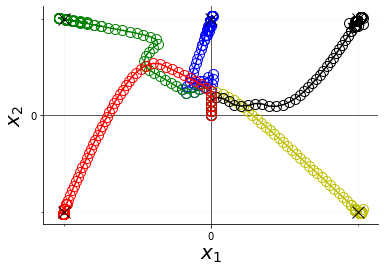

[1. 1. 1. 1. 1.]
Targets are reached.


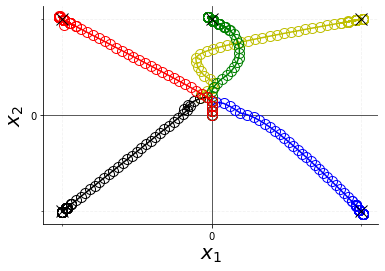

[1. 1. 1. 1. 1.]
Targets are reached.


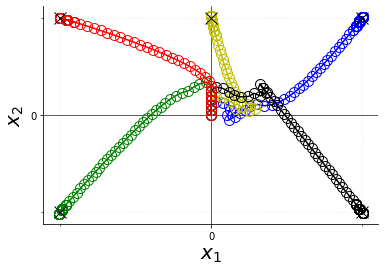

[1. 1. 1. 1. 1.]
Targets are reached.


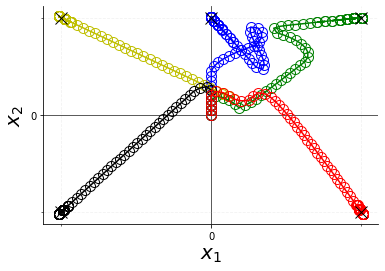

[1. 1. 1. 1. 1.]
Targets are reached.


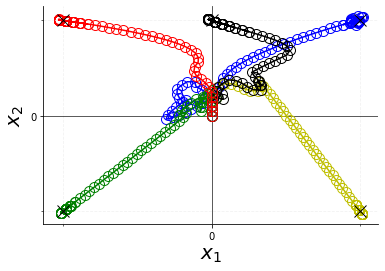

[1. 1. 1. 1. 1.]
Targets are reached.


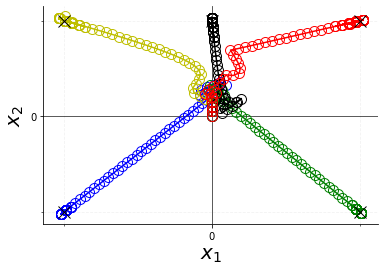

[1. 1. 1. 1. 1.]
Targets are reached.


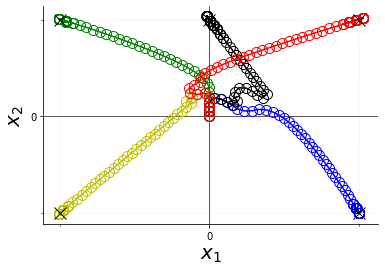

[1. 1. 1. 1. 1.]
Targets are reached.


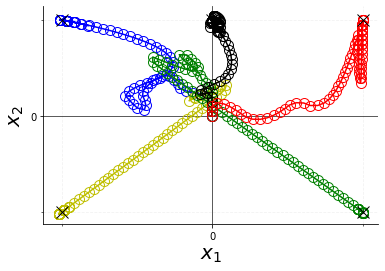

[1. 1. 1. 1. 1.]
Targets are reached.


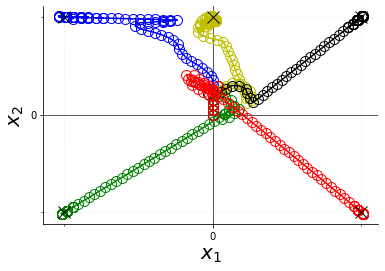

[1. 1. 1. 1. 1.]
Targets are reached.


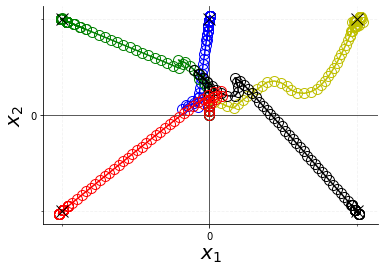

[1. 1. 1. 1. 1.]
Targets are reached.


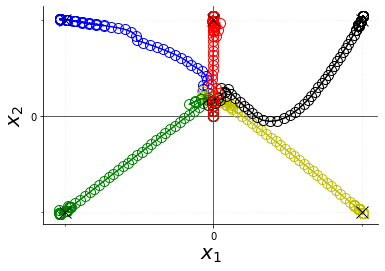

[1. 1. 1. 1. 1.]
Targets are reached.


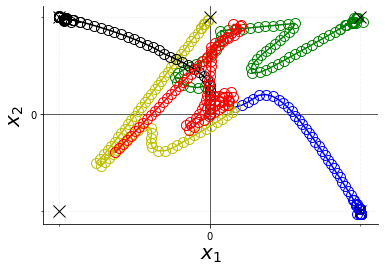

[1. 1. 1. 1. 1.]
Not reached.


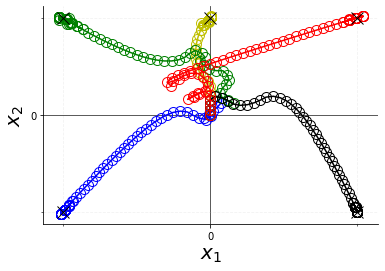

[1. 1. 1. 1. 1.]
Targets are reached.


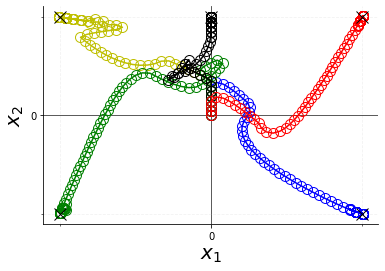

[1. 1. 1. 1. 1.]
Targets are reached.


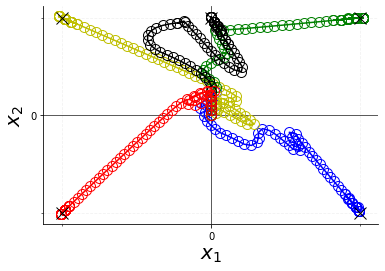

[1. 1. 1. 1. 1.]
Targets are reached.


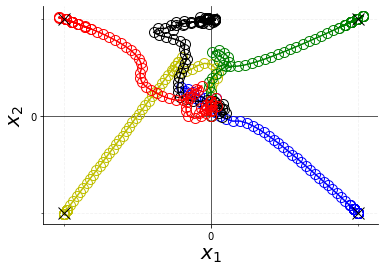

[1. 1. 1. 1. 1.]
Targets are reached.


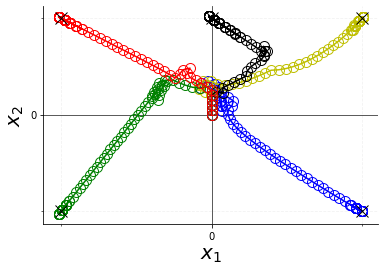

[1. 1. 1. 1. 1.]
Targets are reached.


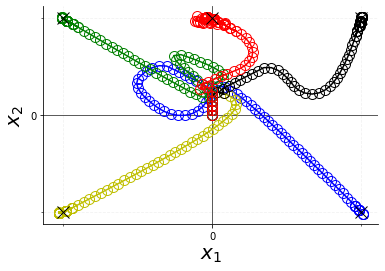

[1. 1. 1. 1. 1.]
Targets are reached.


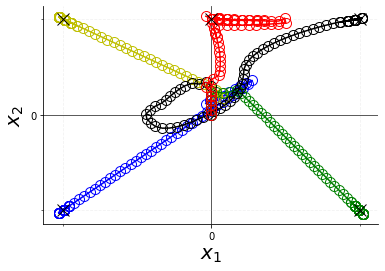

[1. 1. 1. 1. 1.]
Targets are reached.


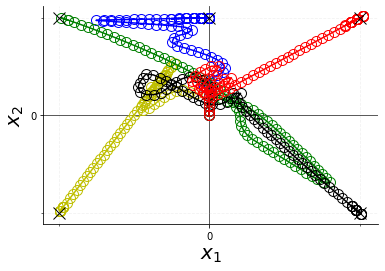

[1. 1. 1. 1. 1.]
Targets are reached.
--------------------------
--------------------------


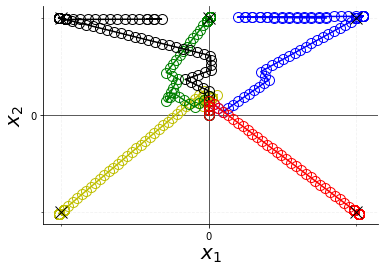

[1. 1. 1. 1. 1.]
Not reached.


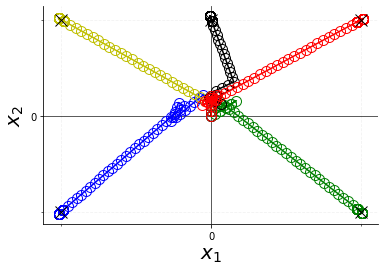

[1. 1. 1. 1. 1.]
Targets are reached.


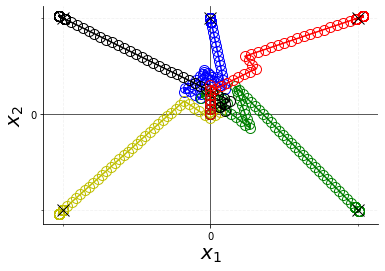

[1. 1. 1. 1. 1.]
Targets are reached.


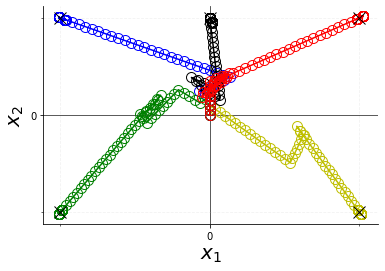

[1. 1. 1. 1. 1.]
Targets are reached.


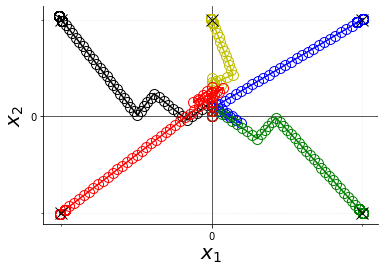

[1. 1. 1. 1. 1.]
Targets are reached.


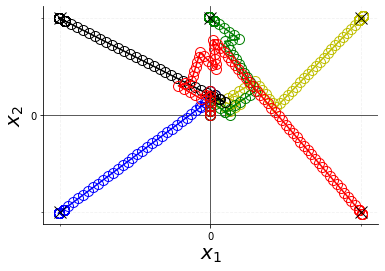

[1. 1. 1. 1. 1.]
Targets are reached.


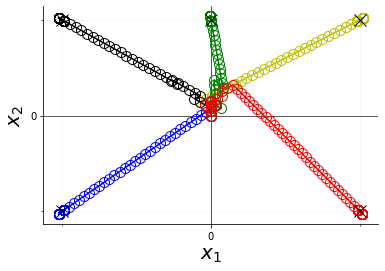

[1. 1. 1. 1. 1.]
Targets are reached.


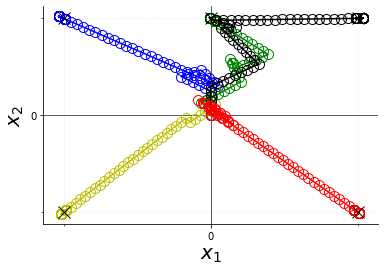

[1. 1. 1. 1. 1.]
Targets are reached.


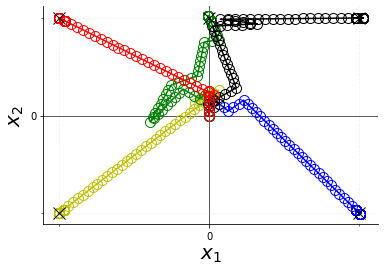

[1. 1. 1. 1. 1.]
Targets are reached.


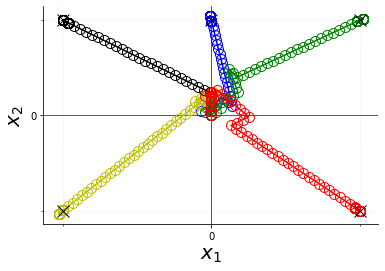

[1. 1. 1. 1. 1.]
Targets are reached.


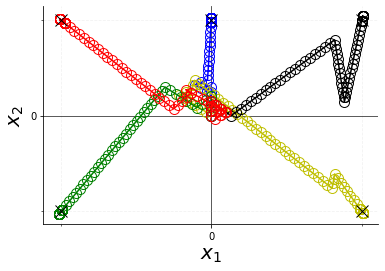

[1. 1. 1. 1. 1.]
Targets are reached.


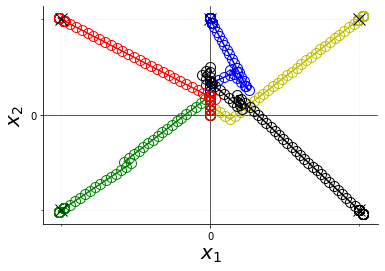

[1. 1. 1. 1. 1.]
Targets are reached.


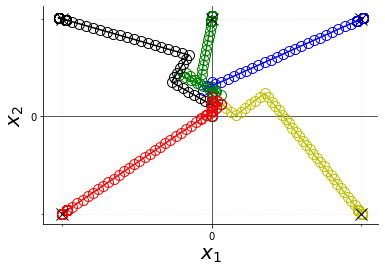

[1. 1. 1. 1. 1.]
Targets are reached.


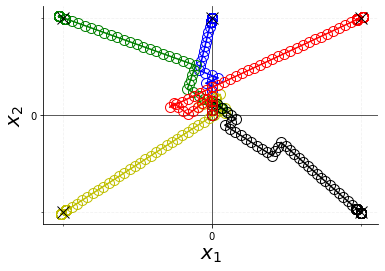

[1. 1. 1. 1. 1.]
Targets are reached.


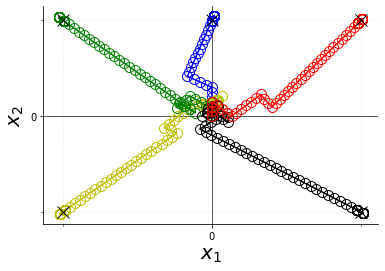

[1. 1. 1. 1. 1.]
Targets are reached.


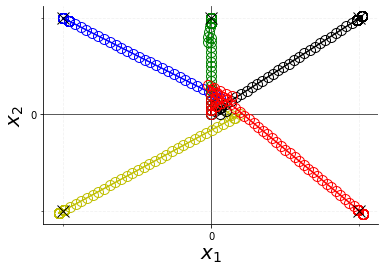

[1. 1. 1. 1. 1.]
Targets are reached.


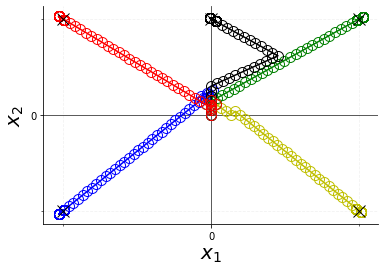

[1. 1. 1. 1. 1.]
Targets are reached.


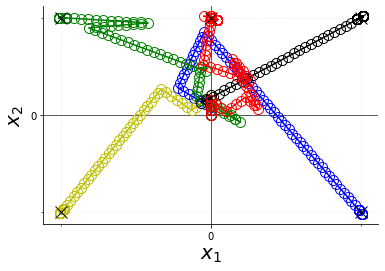

[1. 1. 1. 1. 1.]
Targets are reached.


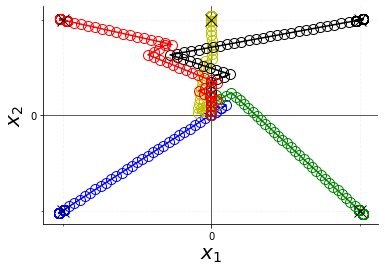

[1. 1. 1. 1. 1.]
Targets are reached.


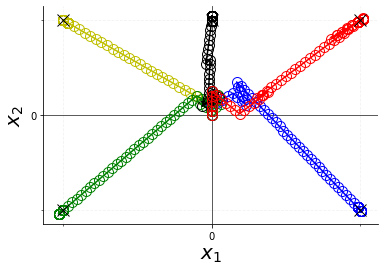

[1. 1. 1. 1. 1.]
Targets are reached.
--------------------------
[19. 19.]


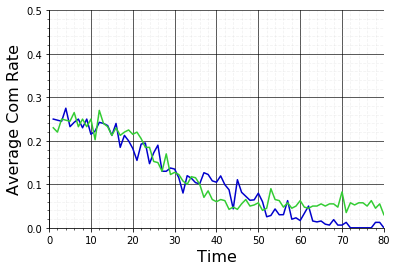

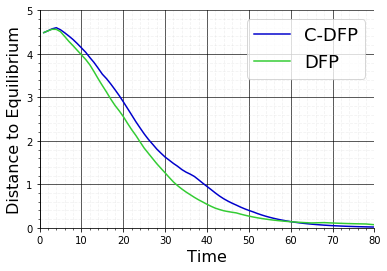

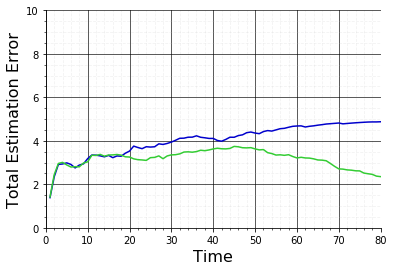

In [101]:
T=80
rho_1=0.1
rho_2=0.9
threshold=0.05
threshold_2=1.6
noa=5

#initial_positions=np.zeros((noa,2))


#initial_positions=np.array([[0,0],[-1,2],[2,1],[-3,4],[4,3]])
#initial_positions=np.array([[0,0],[-1,2],[2,1],[-3,4],[4,3]])
#mean1=[0, 0]
#cov1= [[0.1, 0], [0, 0.1]] 
initial_positions=np.zeros((noa,2))
#initial_positions=np.random.multivariate_normal(mean1, cov1, noa)
#initial_positions=0.5*np.array([[-1,-1],[-1,0],[-1,1],[1,1],[1,-1]])
prior_dist=(1/noa)*np.ones((noa,noa))

#final_positions=np.array([[0,-2.5],[0,2],[5,-4],[-1,7.5],[9,3]])
final_positions=np.array([[-1,1],[0,1],[1,1],[-1,-1],[1,-1]])
#final_positions=np.array([[0,0],[-1,3],[1,3],[-1,-3],[1,-3]])
#final_positions=np.array([[-1,1],[1,1],[0,2],[-1,3],[1,3]])
#final_positions=0.5*np.array([[0,0],[-1,-3],[-1,3],[1,3],[1,-3]])
#final_positions=6 * np.random.random_sample((20, 2)) - 3

#final_positions=np.array([point(0,0,1) for _ in range(noa)])




#print(final_positions)
#plt.scatter(*zip(*xy))
#plt.grid(color='k', linestyle=':', linewidth=1)
#plt.axes().set_aspect('equal', 'datalim')
#plt.show()
alpha_max=1

print_option=0
#sim=simIns(noa,initial_positions,prior_dist,T,threshold,alpha_max,final_positions,1)
#sim.run(rho_1,prob_eps,rho_2)

version=0

sims=simulation(noa,initial_positions,prior_dist,T,threshold,threshold_2,alpha_max,final_positions,print_option,version)
               
#prob_eps=np.array([0.70, 0.8, 0.85])
#rhos=0.2

rep=20
#rhos=np.array([0.1, 0.2, 0.4])
prob_eps=0.90

#thresholds=np.array([0.1, 0.2, 0.3])
#sims.repParam(rep,thresholds,rhos,prob_eps,1)
#sims.replicate(rep,rho_1,prob_eps,rho_2)
#sims.repVersions(rep,rho_1,prob_eps,rho_2)
sims.repVersionsCCTA(rep,rho_1,prob_eps,rho_2)
#First row rho_1 - Second Row rho_2
#rhos=np.array([[0.1,0.2,0.3,0.5],[0.2,0.4, 0.6, 1]])
#First row threshold_1 - Second Row threshold_2
#thresholds=np.array([[0.1,0.1,0.2,0.2],[0.4, 1.5, 0.4, 1.5]])

#sims.runRhoVsH(rep,rhos,thresholds,version,prob_eps)

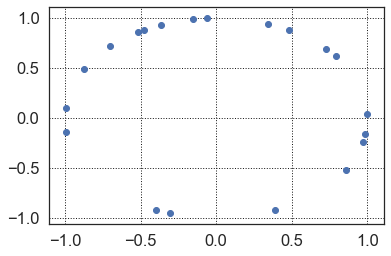

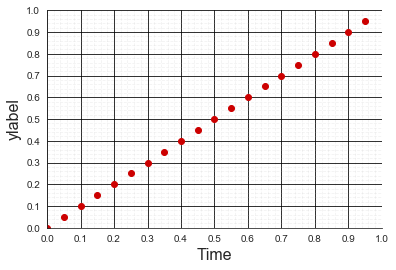

In [49]:



x = np.arange(0, 1, 0.05)
y = np.power(x, 1)

#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.rcParams["font.family"] = "Arial"


fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 2, 0.1))
ax.set_yticks(np.arange(0, 2,0.1))
##cc0000
#0000CC
plt.scatter(x, y, color='#cc0000')
#plt.grid(linestyle='--')


plt.grid(b=False, which='major', color='k', linestyle='-',)
plt.grid(b=False, which='minor', color='silver', linestyle='--', alpha=0.2)
plt.minorticks_on()
#scale_x = 1e-2
#scale_y = 1e4
#ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale_x))
#ax.xaxis.set_major_formatter(ticks_x)

#ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale_y))
#ax.yaxis.set_major_formatter(ticks_y)
#fig.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
#fig.suptitle('test title', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('ylabel', fontsize=16)


plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(np.random.randn(300), 'o-', label='normal distribution',alpha=15)
ax.plot(np.random.rand(300), 's-', label='uniform distribution',alpha=0.4)
ax.set_ylim(-3, 3)

ax.legend(fancybox=True, framealpha=0.5)
ax.set_title('fancy, transparent legends')

plt.show()



In [ ]:

uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data, linewidth=0.5)
plt.show()

In [67]:
selection_model = plp.LpProblem("Selection", plp.LpMinimize)
set_pos=range(9)
y_var=plp.LpVariable.dicts("final_positions", set_pos, 0, 1, plp.LpBinary)


finals=np.random.rand(9,2)
print(finals)
x=np.array([1.3,1])
print(x)
dif=finals-x
print(dif)
dist=np.linalg.norm(dif,axis=1)
print(dist)

selection_model +=  plp.lpSum([y_var[i]*dist[i] for i in set_pos])
selection_model +=  plp.lpSum([y_var[i] for i in set_pos])==1
selection_model.solve()

solution=np.array([selection_model.variables()[i].varValue for i in set_pos ])
print(solution)
print(selection_model.objective.value())

[[0.04559778 0.28211176]
 [0.30991756 0.66449048]
 [0.86255708 0.11710216]
 [0.17054441 0.02990675]
 [0.8257367  0.94414686]
 [0.32032872 0.74033145]
 [0.66007776 0.86058119]
 [0.37311044 0.18218927]
 [0.71620481 0.83391373]]
[1.3 1. ]
[[-1.25440222 -0.71788824]
 [-0.99008244 -0.33550952]
 [-0.43744292 -0.88289784]
 [-1.12945559 -0.97009325]
 [-0.4742633  -0.05585314]
 [-0.97967128 -0.25966855]
 [-0.63992224 -0.13941881]
 [-0.92688956 -0.81781073]
 [-0.58379519 -0.16608627]]
[1.44529874 1.04538504 0.98532477 1.4888757  0.47754083 1.01350066
 0.65493364 1.23609815 0.60696085]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
0.4775408328475067


In [506]:
for i in range(3):
    print(i)

0
1
2


In [18]:
range(8)
print(range(8))

range(0, 8)


In [35]:
a=np.array([[0,1,2,3,4],[5,6,7,8,9]])
ind=np.array([True,True])
print(a[ind][1])


[5 6 7 8 9]


In [43]:
com_list=np.arange(6)
print(com_list)
d=np.delete(com_list,2)
print(d)

[0 1 2 3 4 5]
[0 1 3 4 5]


In [56]:
inds=np.ones(5,dtype=bool) 
inds[3]=False
ls=np.array([5,7,9,11,13])
print(ls[inds])

[ 5  7 11 13]


In [11]:
qw=np.ones(4)
np.reshape(qw,(1,4))
print(qw)

[1. 1. 1. 1.]


In [14]:
a=np.arange(6)
k=np.reshape(a, (2, 3))
print(k)

[[0 1 2]
 [3 4 5]]


In [39]:
r=np.identity(5)
r_dif=r-r[0]
print(r_dif)
np.linalg.norm(r_dif,axis=1)

[[ 0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.]
 [-1.  0.  1.  0.  0.]
 [-1.  0.  0.  1.  0.]
 [-1.  0.  0.  0.  1.]]


array([2., 1., 1., 1., 1.])

In [510]:

t=np.array([[1,2,3],[5,6,7]])
tt=np.ones(3)
print(t-tt)


[[0. 1. 2.]
 [4. 5. 6.]]


In [5]:
ddd=np.array([0,1,0,0])
dfd=np.array(ddd,dtype=bool)
print(ddd[dfd])


[1]


In [237]:
er=np.array([])
print(er)
er=np.concatenate((er,np.array([1])),axis=0)
print(er)

[]
[1.]


In [278]:
er=np.array([0.25, 0.25, 0.25, 0.25])
asd=(er>=0.25).sum()
print(asd)

4


In [315]:
rte=np.array([1,2,3,4,5]).ta
rtee=np.repeat(rte,3,axis=1)
print(rtee)

AxisError: axis 1 is out of bounds for array of dimension 1

In [45]:
def g(x):
    y0 = x + 1
    y1 = x * 3
    y2 = y0 ** x
    return {'y0': y0, 'y1': y1 ,'y2': y2}

In [48]:
result=g(3)
print(result['y0'])
print(result['y1'])
print(result['y2'])

4
9
64


In [179]:
aaa=np.array([[1,2,3],[4,5,6]])
mm=aaa.min(axis=0)
print(aaa[0,1])

2


In [13]:
print(np.size(np.array([0.4])))

ppp=np.size(np.array([0.4]))
for i in range(ppp):
    print(str(i))
    print("Sarper")


1
0
Sarper


In [149]:
np.amax([0,5])

5

In [104]:
a = np.array([-1, 0,0, 1, 2, 1,3])
aa=np.array(a,dtype=float)
b = np.array([ 0, 0,3, 0, 2, 2,2],dtype=float)

# If you don't pass `out` the indices where (b == 0) will be uninitialized!
c = np.divide(aa, b, out=np.zeros_like(aa), where=b!=0)
print(c)

[0.  0.  0.  0.  1.  0.5 1.5]


In [15]:
data = np.array([[0,0,0,0,0],
                [0,0,0,0,0],
                [11,12,13,14,15],
                [16,17,18,19,0]])

np.any(data, axis=1)

array([False, False,  True,  True])

In [103]:
eq = np.array([[0,1,0,0,0],
                [0,1,0,0,0],
                [1,0,0,0,0],
                [0,0,0,1,0]])
print(eq)
print(np.sum(eq,axis
             =0))
print(np.shape(eq)[0])


[[0 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]
[1 2 0 1 0]
4


In [72]:
dde=np.array([0, 0.5, 0.7,0 ,0.9])
#print(np.nonzero(dde))
#nzero=np.nonzero(dde)
#print(nzero[0])
aaa=dde!=0
print(aaa)
dde[aaa]

[False  True  True False  True]


array([0.5, 0.7, 0.9])

In [183]:
f_est = np.array([[0.1,0.8,0.1,0,0],
                [0.7,0.1,0.05,0.1,0.05],
                [0,0,0.9,0.05,0.05],
                [0,0.65,0,0.35,0],
                 [0,0.99,0,0.01,0]])

argmax_f=np.argmax(f_est,axis=1)
max_f=np.max(f_est,axis=1)

print(max_f)
print(argmax_f)

#print(np.in1d(np.array([0,1,2,3,4]),argmax_f))
#print(np.in1d( np.array([0,1,2,3,4]), np.array([0,0,0,0,1])))


equ_ex1=np.zeros((5,5))

#for i in range(5):
#    print(str(i)+' '+str(argmax_f[i]))
#
equ_ex1[range(5),argmax_f]=1

#print(equ_ex1)

sel_agents=np.sum(equ_ex1,axis=0)



mt1_sel_agents=sel_agents>1

z_sel_agents=sel_agents==0


ss_agents=sel_agents-1
ss_agents=ss_agents.astype(int)
print(ss_agents)

more_inds=ss_agents>0

kk=np.shape(np.arange(5)[more_inds])[0]
print(kk)
senttt=np.array([])

j=0
for i in range(kk):
    
    np.concatenate((sentt,np.array([]])),axis=0) 

    
print(senttt)


#print(mt1_sel_agents)
#print(z_sel_agents)

#print(equ_ex1[:,mt1_sel_agents])

#col_ind=equ_ex1[:,mt1_sel_agents]==1

#col_ind=col_ind.flatten('F')
#print(col_ind)

#print(np.arange(5)[col_ind])
#print(np.arange(5)[mt1_sel_agents])
#print(np.arange(5)[z_sel_agents])

[0.8  0.7  0.9  0.65 0.99]
[1 0 2 1 1]
[ 0  2  0 -1 -1]
1


TypeError: only integer scalar arrays can be converted to a scalar index

In [196]:
a_final= np.array([[1,0,0,0,0],
                [1,0,0,0,0],
                [0,1,0,0,0],
                [0,1,0,0,0],
                 [0,0,1,0,0]])

col_sum=np.sum(a_final,axis=0)

print(col_sum)

mt1_inds=col_sum>1
zero_inds=col_sum==0


print(np.sum(mt1_inds)) ## toplamda kac tane fazlasi olan columnlari
print(zero_inds)

mt1_row_inds=a_final[:,mt1_inds]==1
#mt1_row_inds=mt1_row_inds.flatten('F')

print(mt1_row_inds)
#print(np.arange(5)[mt1_row_inds])

[2 2 1 0 0]
2
[False False False  True  True]
[[ True False]
 [ True False]
 [False  True]
 [False  True]
 [False False]]


In [238]:
f_est = np.array([[0.7,0.2,0.1,0,0],
                [0.7,0.15,0.05,0.1,0],
                [0,0.5,0.9,0.05,0],
                [0,0.65,0,0.35,0],
                 [0,0.99,0,0.01,0]])


argmax_f=np.argmax(f_est[:,1],axis=0)
    
all_inds=np.arange(5)






for i in range(5):
    
    argmax_f_i=np.argmax(f_est[:,i],axis=0)
 
    print(str(i)+' '+str(argmax_f_i))
    
    
    non_argmax_inds=all_inds!=i
    
    final_equ[argmax_f_i,i]=1

    
    
    
    f_est[argmax_f_i,i]=1
    
    f_est[argmax_f_i,non_argmax_inds]=-1
    print(f_est)
  
    
f_est[f_est==-1]=0
print(f_est)





0 0
[[ 1.   -1.   -1.   -1.   -1.  ]
 [ 0.7   0.15  0.05  0.1   0.  ]
 [ 0.    0.5   0.9   0.05  0.  ]
 [ 0.    0.65  0.    0.35  0.  ]
 [ 0.    0.99  0.    0.01  0.  ]]
1 4
[[ 1.   -1.   -1.   -1.   -1.  ]
 [ 0.7   0.15  0.05  0.1   0.  ]
 [ 0.    0.5   0.9   0.05  0.  ]
 [ 0.    0.65  0.    0.35  0.  ]
 [-1.    1.   -1.   -1.   -1.  ]]
2 2
[[ 1.   -1.   -1.   -1.   -1.  ]
 [ 0.7   0.15  0.05  0.1   0.  ]
 [-1.   -1.    1.   -1.   -1.  ]
 [ 0.    0.65  0.    0.35  0.  ]
 [-1.    1.   -1.   -1.   -1.  ]]
3 3
[[ 1.   -1.   -1.   -1.   -1.  ]
 [ 0.7   0.15  0.05  0.1   0.  ]
 [-1.   -1.    1.   -1.   -1.  ]
 [-1.   -1.   -1.    1.   -1.  ]
 [-1.    1.   -1.   -1.   -1.  ]]
4 1
[[ 1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  1.]
 [-1. -1.  1. -1. -1.]
 [-1. -1. -1.  1. -1.]
 [-1.  1. -1. -1. -1.]]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]


In [76]:
qq=np.array([1.234235423523523523523523523])
print(np.around(qq,decimals=5))

[1.23424]


In [11]:
mean = (1, 2)
cov = [[1, 0], [0, 1]]
x = np.random.multivariate_normal(mean, cov, 20)
print(x)

[[ 1.93327142  1.70160009]
 [ 0.09150303  0.78306172]
 [ 0.97736793  1.684374  ]
 [ 0.80143822  1.56976912]
 [ 1.39462844  4.08087624]
 [-0.6541309   1.70448426]
 [ 1.5153871   1.892251  ]
 [ 1.84362981  1.00638364]
 [ 1.72871476  1.69242531]
 [ 1.36163103  2.45965834]
 [ 1.73059386 -0.66510191]
 [ 1.39176979  1.86271644]
 [ 1.79708895  2.97132836]
 [ 2.10542456  1.3708437 ]
 [-1.21463558  1.5208191 ]
 [ 0.00464794  1.08536583]
 [ 1.19917518  0.95294607]
 [ 1.23085834  4.18456548]
 [ 2.03788771  3.27726041]
 [ 1.39981636  0.88256539]]


[0.2 0.4 0.6 0.8 1. ]
[(0.1, 0.2), (0.2, 0.4), (0.3, 0.8), (0.4, 1)]
[[(0.1, 0.2), (0.2, 0.4), (0.3, 0.6), (0.4, 0.8), (0.5, 1.0)], [(0.3, 0.2), (0.7, 0.5), (0.6, 0.8), (0.4, 0.1), (0.9, 1.0)]]
$ρ_1$                   0.1       0.2       0.3       0.4       0.5
$ρ_2$                   0.2       0.4       0.6       0.8       1.0
$H_{ii}$ $H_{ij}$                                                  
0.3      0.2       1.973687 -0.718641  0.018173  1.277839 -0.909633
0.7      0.5       0.115815 -0.938628  0.242166 -0.897950 -0.751231
0.6      0.8      -1.076766 -1.268783 -1.891068  0.730766  1.265533
0.4      0.1       1.559593  1.037128 -0.252540  1.970386  1.186815
0.9      1.0       0.453184 -0.762661 -0.139189 -0.573141 -0.185409
Avg_Results-Total_Com_Atp Rho_1: 0.3-Rho_2: 2-H_ii: 3-H_ij: 4
5


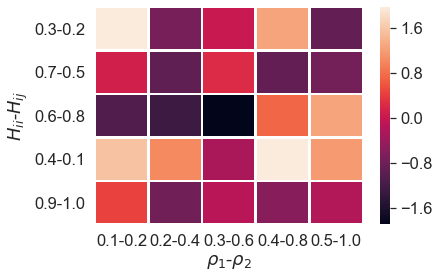

In [208]:
tos=np.array([[0.1,0.2,0.3,0.4,0.5],[0.2,0.4,0.6,0.8,1]])
tos_2=np.array([[0.3,0.7,0.6,0.4,0.9],[0.2,0.5,0.8,0.1,1]])
print(tos[1])
tuples_1 = list(zip(*tos))
tuples_2 = list(zip(*tos_2))
print(tuples)
lists=[tuples_1,tuples_2]
print(lists)
index1 = pd.MultiIndex.from_tuples(tuples_1, names=['$\u03C1_1$', '$\u03C1_2$'])
index2=pd.MultiIndex.from_tuples(tuples_2, names=['$H_{ii}$', '$H_{ij}$'])
ind_prod=pd.MultiIndex.from_product(lists, names=['rhos', 'H'])

row=ind_prod.get_level_values(0)
col=ind_prod.get_level_values(1)
#ind_prod.size
df = pd.DataFrame(np.random.randn(5,5), index=index2,columns=index1)
print(df)

sns.set(font_scale=1.5)

ax = sns.heatmap(df,linewidths=1.5)
file_name_com="Avg_Results-Total_Com_Atp Rho_1: "+str(tos[0,2])+"-Rho_2: "+str(2)+"-H_ii: "+str(3)+"-H_ij: "+str(4)
print(file_name_com)
print(tos.shape[1])